In [9]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.table import Table
from astropy.io import fits
import h5py
from Payne.fitting.genmod import GenMod

import os

In [16]:
def plot_multi(specNN='', NNtype='', spec_dir='', spec_filename=[''], model_filename='', target='', hecto=True):
    if not specNN:
        raise ValueError("specNN is empty. Please provide a value.")
    if not NNtype:
        raise ValueError("NNtype is empty. Please provide a value.")
    if not spec_dir:
        raise ValueError("spec_dir is empty. Please provide a value.")
    if not spec_filename:
        raise ValueError("spec_filename is empty. Please provide a value.")
    if not model_filename:
        raise ValueError("model_filename is empty. Please provide a value.")
    if (not target) and (hecto == True):
        raise ValueError("target is empty. Please provide a value.")


    fig, ax = plt.subplots()

    # Read in observed spectra
    if hecto:
        specs = []
        
        for i, data in enumerate(spec_filename):
            spec_path = os.path.join(spec_dir, data)
            f = h5py.File(spec_path, 'r')
            
            spec = Table([f[target]['wave'], f[target]['flux'], \
                          f[target]['eflux']], \
                         names=('waveobs', 'flux', 'err'))

            specs.append(spec)
        # print(specs)

    else:
        specs = []
        for i, file in enumerate(spec_filename):
            spec_path = os.path.join(spec_dir, file)
            # print(spec_path)
            data, header = fits.getdata(spec_path, header=True)
            specs.append(data)
        # print(len(specs), specs)
        
    # Plot the observed spectra
    for i, spec in enumerate(specs):
        ax.plot(spec['waveobs'], spec['flux'], label=f'Observed spectrum {i}', alpha=0.5)

    wave_min = np.amin(spec['waveobs'])
    wave_max = np.amax(spec['waveobs'])
    ax.set_xlim(int(wave_min), int(wave_max))
    

    # Treat the model spectra
    # initialize model generation class
    GM = GenMod()
    GM._initspecnn(
        nnpath=specNN,
        NNtype=NNtype)

    # Read in model spectrum parameters
    model_filename = os.path.expanduser(model_filename)
    data, header = fits.getdata(model_filename, header=True)
    
    for i in range(len(spec_filename)):    
        starpars = ([
                np.median(data['Teff']), # Teff
                np.median(data['log(g)']), # log(g)
                np.median(data['[Fe/H]']), # [Fe/H]
                np.median(data['[a/Fe]']), # [a/Fe]
                np.median(data[f'vrad_{i}']), # vrad
                np.median(data['vstar']), # vstar
                np.median(data['vmic']), # vmic
                np.median(data[f'lsf_{i}']), # lsf (R)
                np.median(data[f'pc0_{i}']), # pc0
                np.median(data[f'pc1_{i}']), # pc1
                np.median(data[f'pc2_{i}']), # pc2
                np.median(data[f'pc3_{i}']), # pc3
                ])
        
        # generate the model, output is an array of [wave,flux]
        specmod = GM.genspec(starpars, modpoly=True)
        
        # Plot the models
        ax.plot(specmod[0], specmod[1], label=f'Model spectrum {i}', alpha=0.5, ls='--')
    
        # Free up memory
        del specmod
        del starpars

    ax.grid()
    plt.title('UberMS Multiple Spectrum Analysis (UTP)')
    ax.set_xlabel(r"$\lambda$ (nm)")
    ax.set_ylabel(r"$F_{\lambda}$")
    plt.legend()
    plt.show()

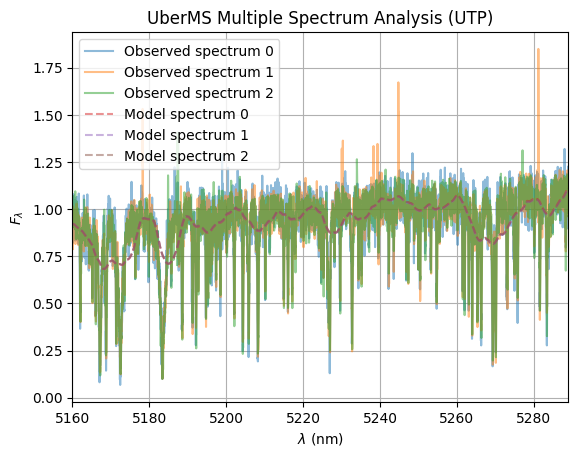

In [17]:
specNN='/data/labs/douglaslab/sofairj/demo_dva_2/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'

spec_dir="/data/labs/douglaslab/sofairj/data/hecto_spectra"
spec_filename=["data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5", "data_ngc6811_2019.0623_hectochelle_NGC6811_2019b_1.8441.h5", "data_ngc6811_2019.0624_hectochelle_NGC6811_2019b_2.8536.h5"]
model_filename="/data/labs/douglaslab/sofairj/demo_dva_2/samples/hectoUTP_multi_2.fits"

# 2080061393129929088 is the first star listed in the spectra used here
target=str(2080061393129929088)
hecto=True

# plot_multi(specNN, NNtype, [starpars1, starpars2, starpars3], spec_dir, spec_filename, target, hecto)
plot_multi(specNN=specNN, NNtype=NNtype, spec_dir=spec_dir, spec_filename=spec_filename, model_filename=model_filename, target=target, hecto=hecto)

In [7]:
def plot_single(specNN='', NNtype='', spec_dir='', spec_filename='', model_filename='', target='', hecto=True):
    if not specNN:
        raise ValueError("specNN is empty. Please provide a value.")
    if not NNtype:
        raise ValueError("NNtype is empty. Please provide a value.")
    # if not starpars or (len(starpars) == 1 and starpars[0] == 0.0):
    #     raise ValueError("starpars is empty or 0.0. Please provide a value.")
    if not spec_dir:
        raise ValueError("spec_dir is empty. Please provide a value.")
    if not spec_filename:
        raise ValueError("spec_filename is empty. Please provide a value.")
    if not model_filename:
        raise ValueError("model_filename is empty. Please provide a value.")
    if not target:
        raise ValueError("target is empty. Please provide a value.")

    # Read in model spectrum parameters
    model_filename = os.path.expanduser(model_filename)
    data, header = fits.getdata(model_filename, header=True)

    starpars = ([
            np.median(data['Teff']), # Teff
            np.median(data['log(g)']), # log(g)
            np.median(data['[Fe/H]']), # [Fe/H]
            np.median(data['[a/Fe]']), # [a/Fe]
            np.median(data['vrad']), # vrad
            np.median(data['vstar']), # vstar
            np.median(data['vmic']), # vmic
            np.median(data['lsf']), # lsf (R)
            np.median(data['pc0']), # pc0
            np.median(data['pc1']), # pc1
            np.median(data['pc2']), # pc2
            np.median(data['pc3']), # pc3
            ])
    
    # initialize model generation class
    GM = GenMod()
    GM._initspecnn(
        nnpath=specNN,
        NNtype=NNtype)
    
    # generate the model, output is an array of [wave,flux]
    specmod = GM.genspec(starpars, modpoly=True)

    # Read in spectrum
    spec_path = os.path.join(spec_dir, spec_filename)
    f = h5py.File(spec_path, 'r')

    if hecto:
        # 2080061393129929088 is the first star listed in the spectrum used here
        # (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
        spec = Table([f[target]['wave'], f[target]['flux'], \
                      f[target]['eflux']], \
                     names=('wave', 'flux', 'err'))
        # print(spec[:5])

    # Plot the data vs. the model
    fig = plt.figure(figsize=(10,8))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 0.1], hspace=0)  # The last row is for padding

    # Plot the model and spectra
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(spec['wave'], spec['flux'], c='#0073e6', label='Observed spectrum')
    ax1.plot(specmod[0], specmod[1], c='#f57600', label='Model spectrum')

    wave_min = np.amin(spec['wave'])
    wave_max = np.amax(spec['wave'])
    ax1.set_xlim(int(wave_min), int(wave_max))
    ax1.tick_params(axis='x', which='both', labelbottom=False)
    
    ax1.set_ylabel(r"$F_{\lambda}$")
    ax1.set_title('UberMS Single Spectrum Analysis (UTP)')
    ax1.legend()


    # Plot residuals
    ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Share x-axis with ax1
    
    specmod_flux_interp = np.interp(spec['wave'], specmod[0], specmod[1])
    residuals_average = np.mean(spec['flux'] - specmod_flux_interp)

    ax2.plot(spec['wave'], spec['flux'] - specmod_flux_interp, c='#0073e6', label='Residuals')
    
    ax2.set_xlabel("$\lambda$ (nm)")
    ax2.set_ylabel("Residuals")
    ax2.axhline(y=0, c='black')
   
    # ax2.text(0.5, 9.5, f"Average: {residuals_average}", fontsize=14, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    plt.show()

    print(residuals_average)

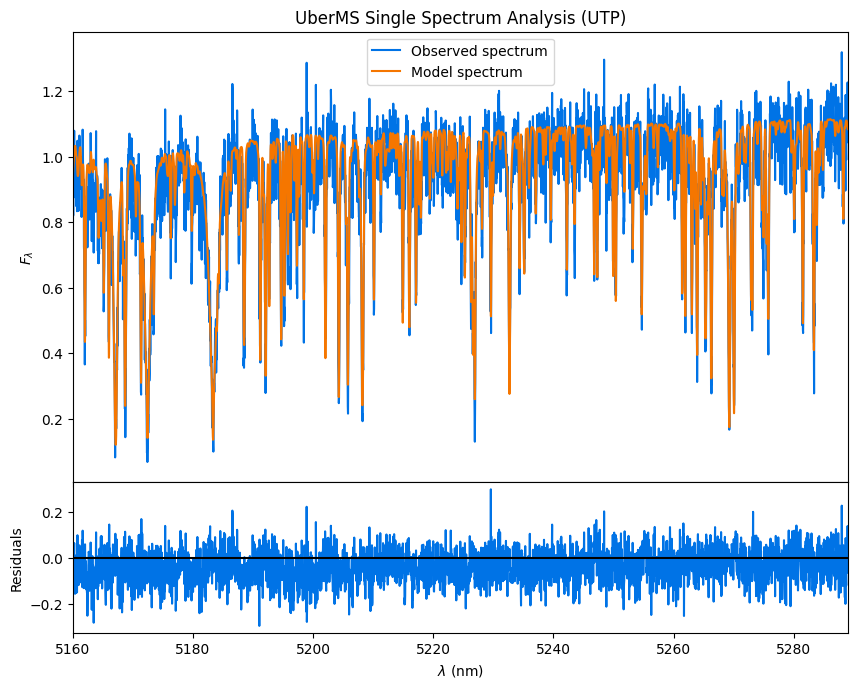

-0.03741608620742582


In [9]:
specNN='/data/labs/douglaslab/sofairj/demo4/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'
# starpars = ([
#             5564.35, # Teff
#             4.16, # log(g)
#             -0.12, # [Fe/H]
#             0.11, # [a/Fe]
#             -98.13, # vrad
#             2.74, # vstar
#             1.0, # vmic
#             32007.42, # lsf (R)
#             1.08, # pc0
#             0.06, # pc1
#             0.0, # pc2
#             0.0, # pc3
#             ])
spec_dir="/data/labs/douglaslab/sofairj/data/hecto_spectra"
spec_filename="data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5"
model_filename="/data/labs/douglaslab/sofairj/demo4/samples/hecto_tp_ds_dp_wide_priors_3_best_guess.fits"
target=str(2080061393129929088)
hecto=True


# plot_single(specNN, NNtype, starpars, spec_dir, spec_filename, target, hecto)
plot_single(specNN, NNtype, spec_dir, spec_filename, model_filename, target, hecto)

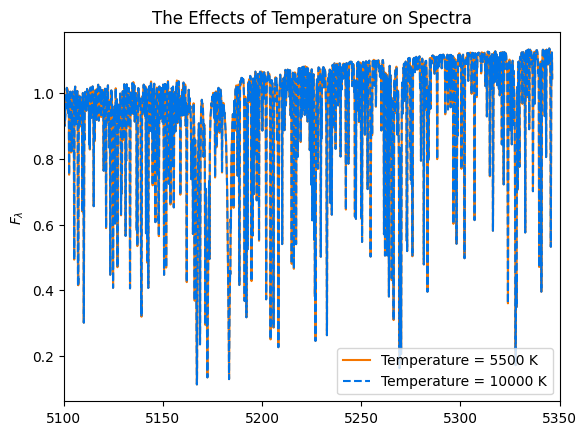

In [39]:
specNN='/data/labs/douglaslab/sofairj/demo4/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'

# spec_dir="/data/labs/douglaslab/sofairj/data/hecto_spectra"
# spec_filename="data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5"
model_filename="/data/labs/douglaslab/sofairj/demo4/samples/hecto_tp_ds_dp_wide_priors_3_best_guess.fits"
target=str(2080061393129929088)
hecto=True

# plot_single(specNN, NNtype, spec_dir, spec_filename, model_filename, target, hecto)

# Read in model spectrum parameters
model_filename = os.path.expanduser(model_filename)
data, header = fits.getdata(model_filename, header=True)

teff1 = 5500
teff2 = 10000

logg1 = 3.45
logg2 = 4.13

feh1 = 0.36
feh2 = 0.70

afe1 = 0.1
afe2 = 0.6

starpars = ([
        teff1, # Teff
        np.median(data['log(g)']), # log(g)
        np.median(data['[Fe/H]']), # [Fe/H]
        np.median(data['[a/Fe]']), # [a/Fe]
        np.median(data['vrad']), # vrad
        np.median(data['vstar']), # vstar
        np.median(data['vmic']), # vmic
        np.median(data['lsf']), # lsf (R)
        np.median(data['pc0']), # pc0
        np.median(data['pc1']), # pc1
        np.median(data['pc2']), # pc2
        np.median(data['pc3']), # pc3
        ])

# initialize model generation class
GM = GenMod()
GM._initspecnn(
    nnpath=specNN,
    NNtype=NNtype)

# generate the model, output is an array of [wave,flux]
specmod = GM.genspec(starpars, modpoly=True)

# Plot the model and spectra
fig, ax = plt.subplots()
# ax = fig.add_subplot(gs[0])
# ax.plot(spec['wave'], spec['flux'], c='#0073e6', label='Observed spectrum')
ax.plot(specmod[0], specmod[1], c='#f57600', label=f'Temperature = {teff1} K')

wave_min = np.amin(specmod[0])
wave_max = np.amax(specmod[0])
ax.set_xlim(int(wave_min), int(wave_max))
# ax.tick_params(axis='x', which='both')
ax.set_xticks([5100, 5150, 5200, 5250, 5300, 5350])

ax.set_ylabel(r"$F_{\lambda}$")
ax.set_title('The Effects of Temperature on Spectra')

del GM
del specmod

# initialize model generation class
GM = GenMod()
GM._initspecnn(
    nnpath=specNN,
    NNtype=NNtype)

# generate the model, output is an array of [wave,flux]
specmod = GM.genspec(starpars, modpoly=True)

starpars = ([
        teff1, # Teff
        logg2, # log(g)
        np.median(data['[Fe/H]']), # [Fe/H]
        np.median(data['[a/Fe]']), # [a/Fe]
        np.median(data['vrad']), # vrad
        np.median(data['vstar']), # vstar
        np.median(data['vmic']), # vmic
        np.median(data['lsf']), # lsf (R)
        np.median(data['pc0']), # pc0
        np.median(data['pc1']), # pc1
        np.median(data['pc2']), # pc2
        np.median(data['pc3']), # pc3
        ])

ax.plot(specmod[0], specmod[1], c='#0073e6', label=f'Temperature = {teff2} K', ls='--')

ax.legend()
plt.show()

In [32]:
# set up paths for NN file and NN type
specNN = '/data/labs/douglaslab/sofairj/demo4/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype = 'LinNet'

# initialize model generation class
GM = GenMod()
GM._initspecnn(
    nnpath=specNN,
    NNtype=NNtype)        

In [7]:
# set the stellar parameters
starpars = ([
    5564.35, # Teff
    4.16, # log(g)
    -0.12, # [Fe/H]
    0.11, # [a/Fe]
    -98.13, # vrad
    2.74, # vstar
    1.0, # vmic
    32007.42, # lsf (R)
    1.08, # pc0
    0.06, # pc1
    0.0, # pc2
    0.0, # pc3
    ])

# generate the model, output is an array of [wave,flux]
specmod = GM.genspec(starpars,modpoly=True)

In [8]:
print(type(specmod))
print(specmod)
print(np.shape(specmod))

<class 'tuple'>
(array([5100.32998047, 5100.34698157, 5100.36398273, ..., 5346.21318581,
       5346.23100652, 5346.24882729]), array([0.91594106, 0.90785821, 0.90185584, ..., 1.05836996, 1.04527677,
       1.03306661]))
(2, 14128)


In [9]:
# Read in spectrum
hecto_dir = os.path.expanduser("/data/labs/douglaslab/sofairj/data/hecto_spectra")
hecto_filename = os.path.join(hecto_dir,"data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5")
f = h5py.File(hecto_filename, 'r')


# 2080061393129929088 is the first star listed in the spectrum used here
# (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
target = str(2080061393129929088)
spec = Table([f[target]['wave'], f[target]['flux'], \
              f[target]['eflux']], \
             names=('wave', 'flux', 'err'))
print(spec[:5])

       wave               flux                err        
------------------ ------------------ -------------------
5160.0200104603355 0.8844941932428408 0.06411394859699583
 5160.056067084432 0.8212205415936218 0.06323189898178284
 5160.092123745668 0.8205826439060211 0.06353863357421642
5160.1281804434475 0.9861714923142594 0.06799408825896802
 5160.164237177179 0.9485641085314488 0.06736945041995439


In [ ]:
# spec_dir = '/data/labs/douglaslab/sofairj/data/hecto_spectra/data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5'
# demophot = fits.getheader(demophot_dir)

# phottab = Table.read(spec_dir, format='fits')
# print(phottab)

In [ ]:
# print(int(np.amin(phottab['wave'])),  int(np.amax(phottab['wave'])))

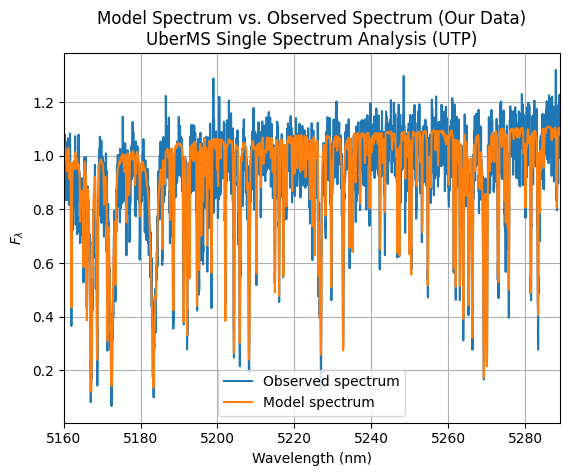

In [10]:
fig, ax = plt.subplots()
ax.plot(spec['wave'], spec['flux'], label='Observed spectrum')
ax.plot(specmod[0], specmod[1], label='Model spectrum')

plt.title('Model Spectrum vs. Observed Spectrum (Our Data)\nUberMS Single Spectrum Analysis (UTP)')
wave_min = np.amin(spec['wave'])
wave_max = np.amax(spec['wave'])

ax.set_xlim(int(wave_min), int(wave_max))
ax.grid()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$F_{\lambda}$")
plt.legend()
plt.show()

In [13]:
# mask = (specmod[0] > wave_min) & (specmod[0] < wave_max)
# specmod_wave_inrange = specmod[0][mask]
# specmod_flux_inrange = specmod[1][mask]

# interpolator = interp1d(specmod_wave_inrange, specmod_flux_inrange)
# flux_large_interpolated = interpolator(spec['wave'])

# Subtract the flux values
# flux_difference = flux_small - flux_large_interpolated

specmod_flux_interp = np.interp(spec['wave'], specmod[0], specmod[1])
residuals_average = np.mean(specmod_flux_interp)

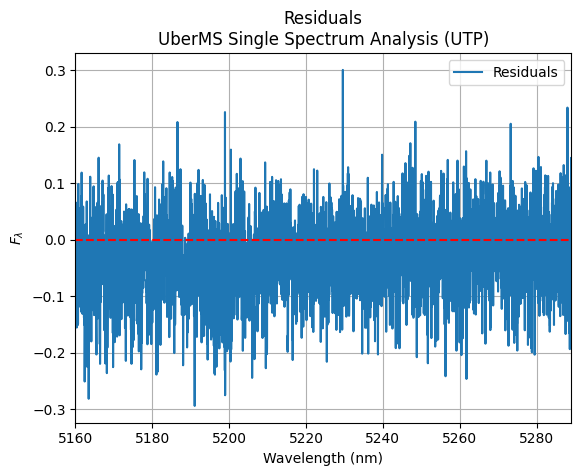

0.941550051495838


In [28]:
fig, ax = plt.subplots()
ax.plot(spec['wave'], spec['flux'] - specmod_flux_interp, label='Residuals')
# ax.plot(spec['wave'], specmod_flux_interp, label='Interpolated model spectrum')

plt.title('Residuals\nUberMS Single Spectrum Analysis (UTP)')
wave_min = np.amin(spec['wave'])
wave_max = np.amax(spec['wave'])

plt.axhline(xmin=0, xmax=1, color='red', ls='--')
# ax.text(0.5, 9.5, f"Average: {residuals_average}", fontsize=14, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

ax.set_xlim(int(wave_min), int(wave_max))
ax.grid()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$F_{\lambda}$")
plt.legend()
plt.show()

print(residuals_average)

In [10]:
# set up paths for NN file and NN type
specNN = '/data/labs/douglaslab/sofairj/demo4/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype = 'LinNet'

# initialize model generation class
GM = GenMod()
GM._initspecnn(
    nnpath=specNN,
    NNtype=NNtype)       

# set the stellar parameters
starpars = ([
    5847.80, # Teff
    4.45, # log(g)
    0.10, # [Fe/H]
    0.06, # [a/Fe]
    0.30, # vrad
    2.78, # vstar
    0.97, # vmic
    28313.24, # lsf (R)
    1.07, # pc0
    -0.01, # pc1
    0.0, # pc2
    0.0, # pc3
    ])

# generate the model, output is an array of [wave,flux]
specmod = GM.genspec(starpars,modpoly=True)

In [18]:
# Read in spectrum
demo_dir = os.path.expanduser("/data/labs/douglaslab/sofairj/demo4/data/")
demo_filename = os.path.join(demo_dir,"demospec_18Sco.fits")
# f = h5py.File(hecto_filename, 'r')

with fits.open(demo_filename) as hdu:
    print(hdu[1].header)

spec, header = fits.getdata(demo_filename, header=True)
print(spec.dtype)
# print(header)
# 2080061393129929088 is the first star listed in the spectrum used here
# (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
# target = str(2080061393129929088)
# spec = Table([f[target]['wave'], f[target]['flux'], \
#               f[target]['eflux']], \
#              names=('wave', 'flux', 'err'))
# print(spec[:5])

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   24 / length of dimension 1                          NAXIS2  =                 1536 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'wave    '                                                            TFORM1  = 'D       '                                                            TTYPE2  = 'flux    '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'err     '                    

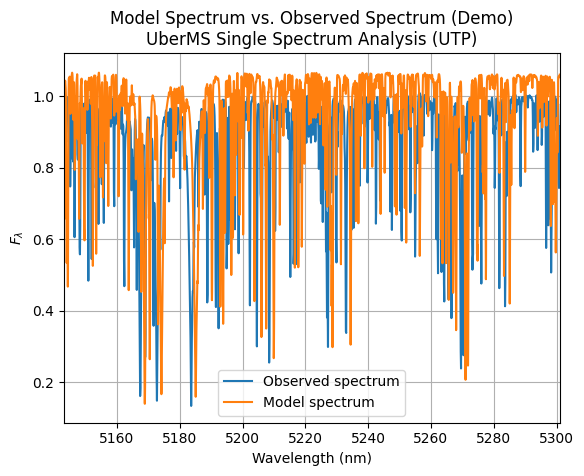

In [20]:
fig, ax = plt.subplots()
ax.plot(spec['wave'], spec['flux'], label='Observed spectrum')
ax.plot(specmod[0], specmod[1], label='Model spectrum')

plt.title('Model Spectrum vs. Observed Spectrum (Demo)\nUberMS Single Spectrum Analysis (UTP)')
wave_min = np.amin(spec['wave'])
wave_max = np.amax(spec['wave'])

ax.set_xlim(int(wave_min), int(wave_max))
ax.grid()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$F_{\lambda}$")
plt.legend()
plt.show()

In [21]:
# set up paths for NN file and NN type
specNN = '/data/labs/douglaslab/sofairj/demo_dva_2/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype = 'LinNet'

# initialize model generation class
GM = GenMod()
GM._initspecnn(
    nnpath=specNN,
    NNtype=NNtype)       

# set the stellar parameters
starpars = ([
    5228.16, # Teff
    4.28, # log(g)
    -0.49, # [Fe/H]
    0.28, # [a/Fe]
    0.27, # vrad
    1.50, # vstar
    0.55, # vmic
    30183.11, # lsf (R)
    1.06, # pc0
    -0.01, # pc1
    0.0, # pc2
    0.0, # pc3
    ])

# generate the model, output is an array of [wave,flux]
specmod = GM.genspec(starpars,modpoly=True)

In [26]:
# Read in spectrum
demo_dir = os.path.expanduser("/data/labs/douglaslab/sofairj/demo_dva_2/data/")
demo_filename = os.path.join(demo_dir,"demophot_tauCet.fits")
# f = h5py.File(hecto_filename, 'r')

with fits.open(demo_filename) as hdu:
    print(hdu.info())
    print(hdu[1].header)

spec, header = fits.getdata(demo_filename, header=True)
print(spec)
# print(header)
# 2080061393129929088 is the first star listed in the spectrum used here
# (data_ngc6811_2019.0516_hectochelle_NGC6811_2019b_1.8149.h5)
# target = str(2080061393129929088)
# spec = Table([f[target]['wave'], f[target]['flux'], \
#               f[target]['eflux']], \
#              names=('wave', 'flux', 'err'))
# print(spec[:5])

Filename: /data/labs/douglaslab/sofairj/demo_dva_2/data/demophot_tauCet.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     14   8R x 3C   [10A, D, D]   
None
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   26 / length of dimension 1                          NAXIS2  =                    8 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'band    '                                                            TFORM1  = '10A    

KeyError: "Key 'wave' does not exist."

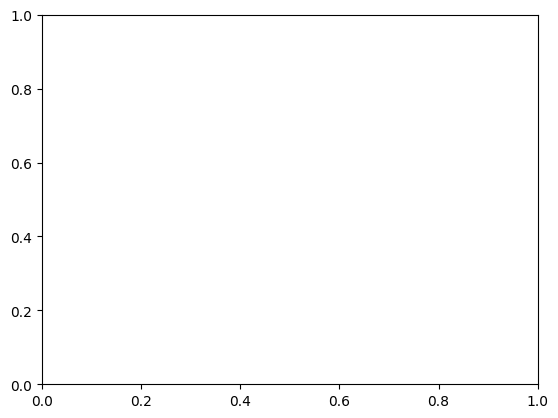

In [23]:
fig, ax = plt.subplots()
ax.plot(spec['wave'], spec['flux'], label='Observed spectrum')
ax.plot(specmod[0], specmod[1], label='Model spectrum')

plt.title('Model Spectrum vs. Observed Spectrum (Demo)\nUberMS Multiple Spectrum Analysis (UTP)')
wave_min = np.amin(spec['wave'])
wave_max = np.amax(spec['wave'])

ax.set_xlim(int(wave_min), int(wave_max))
ax.grid()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel(r"$F_{\lambda}$")
plt.legend()
plt.show()

In [86]:
specmod_inrange = specmod[np.where(specmod[0] > wave_min)[0]]
specmod_inrange = specmod[np.where(specmod[0] < wave_max)[0]]
# print(np.shape(np.where(specmod[0] > wave_min)[0]))
# print(np.shape(np.where(specmod[0] < wave_max)[0]))
print(specmod_inrange)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
fig, ax = plt.subplots()
ax.plot(spec['wave'], spec['flux'], label='Observed spectrum')
ax.plot(specmod[0], specmod[1], label='Model spectrum')

plt.title('Model Spectrum vs. Observed Spectrum\nUberMS Single Spectrum Demo (UTP)')
wave_min = np.amin(spec['wave'])
wave_max = np.amax(spec['wave'])

ax.set_xlim(int(wave_min), int(wave_max))
ax.grid()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux")
plt.legend()
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [60]:
flux_min = np.amin(phottab['flux'])
flux_max = np.amax(phottab['flux'])

specmod_inrange_wave = specmod[0][(specmod[0] > wave_min) & (specmod[0] < wave_max)]
specmod_inrange_flux = specmod[1][(specmod[0] > wave_min) & (specmod[0] < wave_max)]


# specmod_inrange_wave = specmod_inrange_wave[:len(phottab['wave'])]
# specmod_inrange_flux = specmod_inrange_flux[:len(phottab['wave'])]
f = interpolate.interp1d(specmod[0], y)
# specmod_inrange_wave = specmod_inrange_wave[:len(phottab['wave'])]

print(len(specmod[0]))
print(len(specmod_inrange_wave), len(phottab['wave']))

14128
1536 1536


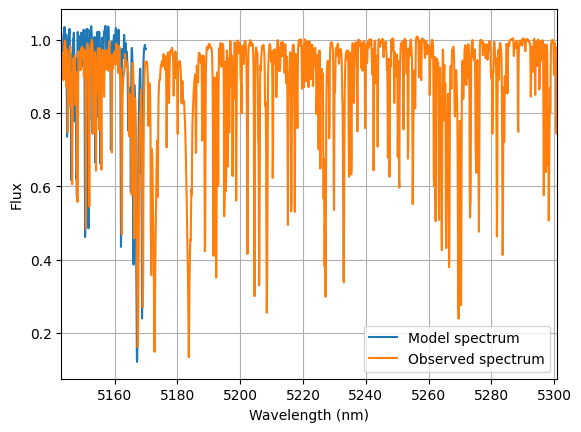

In [61]:
fig, ax = plt.subplots()
ax.plot(specmod_inrange_wave, specmod_inrange_flux, label='Model spectrum')
ax.plot(phottab['wave'], phottab['flux'], label='Observed spectrum')


# plt.title('Observed Spectrum - Model Spectrum\nUberMS Single Spectrum Demo (UTP)')


ax.set_xlim(int(np.amin(phottab['wave'])),  int(np.amax(phottab['wave'])))
ax.grid()
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux")
plt.legend()
plt.show()